In [20]:
#standard package
import pandas as pd
import numpy as np
import os
import math
from collections import Counter
import time 
import glob
import tqdm
import sys
import shutil
import itertools
import pickle
import operator
from operator import itemgetter
import datetime as dt

#topics modeling
import gensim 
from gensim import corpora, models, similarities

#plot
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
from UTILS import word_from_MLP
import config_mobility as config

In [22]:
path_extracted_data = config.path_extracted_data
path_initial_data = config.path_initial_data
id_run = config.id_run
nbr_topics = 2
title_ = '_LB' #'_LB'

In [23]:
#create a director if not existing
path_save = os.path.join(path_extracted_data,'visual','LDA', str(nbr_topics)+title_)
if not os.path.exists(path_save):
    os.makedirs(path_save)

# Download data

In [27]:
df_master = pd.read_csv(os.path.join(path_initial_data,'Mo_Masterfile.csv'), sep=';',parse_dates=['day']) #, parse_dates=['date']) wrong!
df_master.rename(columns={'time':'Timestamp','day':'DayID','hen':'HenID','date':'day'}, inplace=True)
df_master['HenID'] = df_master['HenID'].map(lambda x: 'hen_'+str(x))
print(df_master.shape)
display(df_master.head(3))
#dico_henid_hybrid = dict(zip(df_master['HenID'].tolist(),df_master['hybrid'].tolist()))
li_LB = df_master[df_master['hybrid']=='LB']['HenID'].unique()
li_LSL = df_master[df_master['hybrid']=='LSL']['HenID'].unique()
print(len(li_LB), len(li_LSL))
li_LB[0:2]

(7920, 43)


,HenID,timepoint,group,age,DayID,day,file,severity,pen,hybrid,...,meanchange,mean1,medianchange,transitions,real0,sumdur,nest_vs_total,severity_diff,KBF_new,indicator
0,hen_1,1,A,21,1,27.10.2016,1A01,0.0,1,LSL,...,1.23,1.0,1.0,91.0,NaN,57067.0,0.177419,NaN,0.0,NaN
1,hen_1,1,A,21,2,28.10.2016,1A01,0.0,1,LSL,...,1.28,1.0,1.0,108.0,NaN,56854.0,0.171053,0.0,0.0,NaN
2,hen_1,1,A,21,3,29.10.2016,1A01,0.0,1,LSL,...,1.17,1.0,1.0,128.0,NaN,56721.0,0.255319,0.0,0.0,NaN


60 60


array(['hen_41', 'hen_42'], dtype=object)

In [25]:
#open time series per session and compute the variables for each session (car time series make sence at session level), et en 
#plus des variables tel que running entropy over the whole session ateach last timestamp of each level make sence only at 
#session level
START_TIME = time.clock()
starting_hour = 2
li_path = glob.glob(os.path.join(path_extracted_data, id_run+'_TimeSeries_*.csv'))
li_path = [i for i in li_path if '_hen_' not in i]
li_df = []
for path_ in tqdm.tqdm(li_path):
    
    #download time series associated to this session
    name_ = path_.split('_')[-1].split('.')[0]
    print('-------------------------------------------------------------------------', name_)
    df_ts = pd.read_csv(path_, sep=';', parse_dates=['Timestamp', 'day']) 
    li_hours_to_consider=list(range(starting_hour,17))
    df_ts['is_day'] = df_ts['hour'].map(lambda x: x in li_hours_to_consider)
    print(df_ts.shape)
    df_ts = df_ts[df_ts['is_day']]
    print(df_ts.shape)
    df_ts['session'] = name_
    li_df.append(df_ts)
df_ts = pd.concat(li_df)
print(df_ts.shape)
display(df_ts.head(2))
display(df_ts.tail(2))    
END_TIME = time.clock()
print ("Total running time: %.2f mn" %((END_TIME-START_TIME)/60))  

  0%|                                                                                           | 0/22 [00:00<?, ?it/s]

------------------------------------------------------------------------- 10A
(513000, 54)
(324000, 54)


  5%|███▊                                                                               | 1/22 [00:04<01:44,  5.00s/it]

------------------------------------------------------------------------- 10B


c:\users\camil\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,45,46,47,48,49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(513000, 54)
(324000, 54)


  9%|███████▌                                                                           | 2/22 [00:09<01:39,  4.98s/it]

------------------------------------------------------------------------- 11A
(513000, 46)
(324000, 46)


 14%|███████████▎                                                                       | 3/22 [00:13<01:28,  4.65s/it]

------------------------------------------------------------------------- 11B
(513000, 48)
(324000, 48)


 18%|███████████████                                                                    | 4/22 [00:17<01:19,  4.44s/it]

------------------------------------------------------------------------- 1A
(513000, 64)
(324000, 64)


 23%|██████████████████▊                                                                | 5/22 [00:23<01:22,  4.83s/it]

------------------------------------------------------------------------- 1B
(513000, 63)
(324000, 63)


 27%|██████████████████████▋                                                            | 6/22 [00:29<01:23,  5.23s/it]

------------------------------------------------------------------------- 2A
(513000, 60)
(324000, 60)


 32%|██████████████████████████▍                                                        | 7/22 [00:36<01:25,  5.69s/it]

------------------------------------------------------------------------- 2B
(513000, 65)
(324000, 65)


 36%|██████████████████████████████▏                                                    | 8/22 [00:42<01:22,  5.90s/it]

------------------------------------------------------------------------- 3A
(513000, 63)
(324000, 63)


 41%|█████████████████████████████████▉                                                 | 9/22 [00:49<01:20,  6.18s/it]

------------------------------------------------------------------------- 3B
(513000, 64)
(324000, 64)


 45%|█████████████████████████████████████▎                                            | 10/22 [00:56<01:17,  6.45s/it]

------------------------------------------------------------------------- 4A
(513000, 59)
(324000, 59)


 50%|█████████████████████████████████████████                                         | 11/22 [01:03<01:11,  6.49s/it]

------------------------------------------------------------------------- 4B
(513000, 64)
(324000, 64)


 55%|████████████████████████████████████████████▋                                     | 12/22 [01:09<01:03,  6.38s/it]

------------------------------------------------------------------------- 5A
(513000, 59)
(324000, 59)


 59%|████████████████████████████████████████████████▍                                 | 13/22 [01:14<00:54,  6.03s/it]

------------------------------------------------------------------------- 5B
(513000, 63)
(324000, 63)


 64%|████████████████████████████████████████████████████▏                             | 14/22 [01:19<00:46,  5.78s/it]

------------------------------------------------------------------------- 6A
(513000, 60)
(324000, 60)


 68%|███████████████████████████████████████████████████████▉                          | 15/22 [01:24<00:38,  5.55s/it]

------------------------------------------------------------------------- 6B
(513000, 63)
(324000, 63)


 73%|███████████████████████████████████████████████████████████▋                      | 16/22 [01:30<00:33,  5.62s/it]

------------------------------------------------------------------------- 7A
(513000, 57)
(324000, 57)


 77%|███████████████████████████████████████████████████████████████▎                  | 17/22 [01:36<00:28,  5.61s/it]

------------------------------------------------------------------------- 7B
(513000, 61)
(324000, 61)


 82%|███████████████████████████████████████████████████████████████████               | 18/22 [01:41<00:22,  5.60s/it]

------------------------------------------------------------------------- 8A
(513000, 56)
(324000, 56)


 86%|██████████████████████████████████████████████████████████████████████▊           | 19/22 [01:47<00:16,  5.49s/it]

------------------------------------------------------------------------- 8B
(513000, 62)
(324000, 62)


 91%|██████████████████████████████████████████████████████████████████████████▌       | 20/22 [01:53<00:11,  5.67s/it]

------------------------------------------------------------------------- 9A


c:\users\camil\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(513000, 55)
(324000, 55)


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 21/22 [01:58<00:05,  5.51s/it]

------------------------------------------------------------------------- 9B
(513000, 55)
(324000, 55)


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [02:03<00:00,  5.43s/it]


(7128000, 126)


,Timestamp,day,hen_1,hen_10,hen_100,hen_101,hen_102,hen_103,hen_104,hen_105,...,hen_94,hen_95,hen_96,hen_97,hen_98,hen_99,hour,is_day,nbr_nan,session
1800,2017-07-06 02:00:00,2017-07-06,zone_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2,True,0,10A
1801,2017-07-06 02:00:01,2017-07-06,zone_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2,True,0,10A


,Timestamp,day,hen_1,hen_10,hen_100,hen_101,hen_102,hen_103,hen_104,hen_105,...,hen_94,hen_95,hen_96,hen_97,hen_98,hen_99,hour,is_day,nbr_nan,session
487798,2017-06-14 16:59:58,2017-06-14,NaN,NaN,NaN,zone_5,NaN,zone_2,zone_2,zone_3,...,zone_3,zone_4,zone_5,zone_5,zone_4,zone_2,16,True,0,9B
487799,2017-06-14 16:59:59,2017-06-14,NaN,NaN,NaN,zone_5,NaN,zone_2,zone_2,zone_3,...,zone_3,zone_4,zone_5,zone_5,zone_4,zone_2,16,True,0,9B


Total running time: 2.69 mn


In [31]:
#keep columns of one species only if waned
if title_ =='_LB':
    print(df_ts.shape)
    df_ts = df_ts.filter([x for x in df_ts.columns if (not x.startswith('hen_')) | (x in li_LB)],axis=1)
    print(df_ts.shape)
if title_ =='_LSL':
    print(df_ts.shape)
    df_ts = df_ts.filter([x for x in df_ts.columns if (not x.startswith('hen_')) | (x in li_LSL)],axis=1)
    print(df_ts.shape)

(7128000, 126)
(7128000, 66)


# Topics modelling (lda - latent dirichlet allocation)

### define parameters

In [34]:
#define the fixed number of bouts included in each word
length_words = 3 #TO TEST: 3 et 4
#define 3 size of duration length (small, medium, long) that will be associated to each movement additionally to the daily hour 
dico_size = {'small':range(1,60),
           'intermediate':range(60,15*60),
           'large':range(15*60,60*60*24)}
#dico_size = {'transition':range(1,60),
#            'zone':range(60,60*60*24)}
li_hen = [i for i in df_ts.columns if i.startswith('hen_')]

### documents:  set of words of daily hen time series

In [35]:
documents = {}
for day, df_ in tqdm.tqdm(df_ts.groupby(['day'])):
    df_ = df_.fillna(' ')
    for h in li_hen:
        li = df_[h].tolist()
        #remove if nan in ts or if only one zone (we separate for efficiency)
        if li[0]!=' ':
            if len(set(li))>1:
                documents[h+'/-/'+str(day).split(' ')[0]] = word_from_MLP(li, length_words, starting_hour, dico_size)


 51%|█████████████████████████████████████████                                        | 67/132 [00:55<00:26,  2.41it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 132/132 [01:19<00:00,  2.84it/s]

### frequence analysis

181085 1696


,frequence,word
51,3886,"[['zone_4', 'zone_3', 'zone_4'], ['small', 'sm..."
52,3576,"[['zone_3', 'zone_4', 'zone_3'], ['small', 'sm..."
282,2990,"[['zone_2', 'zone_3', 'zone_2'], ['intermediat..."


,frequence,word
1352,1,"[['zone_4', 'zone_5', 'zone_3'], ['small', 'la..."
1351,1,"[['zone_2', 'zone_4', 'zone_3'], ['large', 'in..."
1695,1,"[['zone_4', 'zone_3', 'zone_2'], ['large', 'la..."


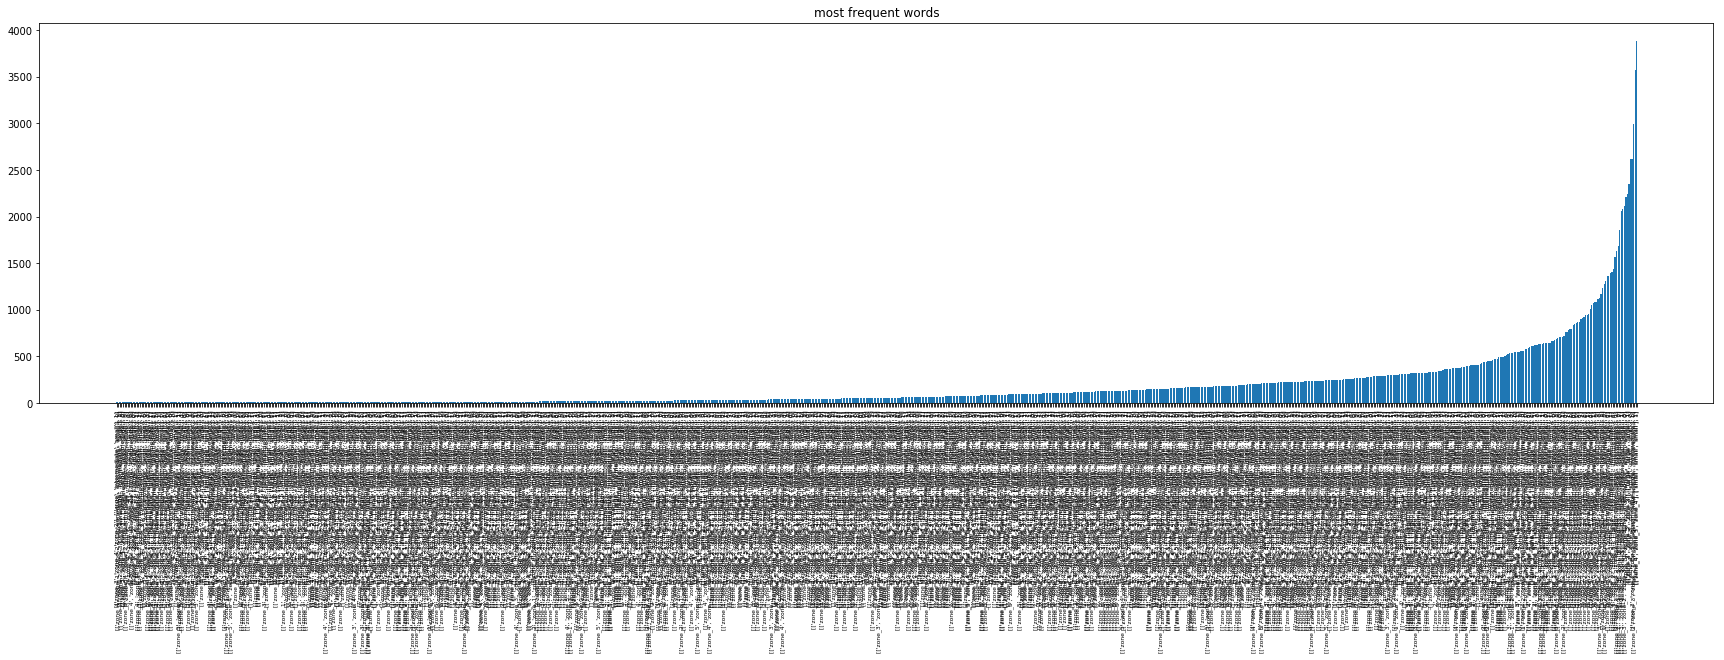

In [36]:
#create a list of all words
li_words = []
for h_day, li_li_tupleWordTime in documents.items():
    #tranform to string to make a dictionary
    li_words.extend([x for x in li_li_tupleWordTime])
print(len(li_words), len(set(li_words)))

#compute frequencies
c_words = Counter(li_words)
df_word_frequence = pd.DataFrame.from_dict({'word':list(c_words.keys()),'frequence':list(c_words.values())})
df_word_frequence = df_word_frequence.sort_values('frequence',ascending=False)
df_word_frequence.to_csv(os.path.join(path_save,'word_Frequence.csv'),index=False,sep=';')
display(df_word_frequence.head(3))
display(df_word_frequence.tail(3))

#simple barplot (sorted with x values)
d = {k:v for k,v in c_words.items() if v>5}
d = sorted(d.items(), key=operator.itemgetter(1))
x = [i[0] for i in d]
y = [i[1] for i in d]
fig = plt.figure(figsize=(30,7))
ax = plt.subplot(111)
width = 0.8
ax.bar(range(len(x)), y, width=width)
plt.title('most frequent words')
ax.set_xticks(np.arange(len(x)) + width/2)
ax.set_xticklabels(x, rotation=90,size=6);
plt.savefig(os.path.join(path_save,'most_frequent_word_'+str(length_words)+'.png'),dpi=300,format='png',bbox_inches='tight')

Text(0,0.5,'number of words')

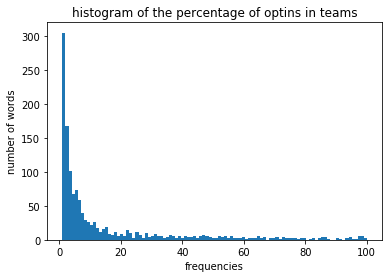

In [37]:
#histogram
plt.hist(df_word_frequence[df_word_frequence['frequence']<=100]['frequence'],bins=100) #into 15 equal parts 
#return: [0]: vector of length bins with #elements in each bins
#and [1]: when the vectors starts (for plot)
plt.title('histogram of the percentage of optins in teams')
plt.xlabel('frequencies')
plt.ylabel('number of words')

In [38]:
#--> choose the nbr_times parameter: number of times a words need to appear at least this amount of time, in the overall set of 
#documents to be taken into account
nbr_times = 13

### clean documents

In [39]:
def MLPsWord4lda(documents, c_words, nbr_times):
    #remove all words appearing less or equal to nbr_times times in the overall time series
    tokens_removed = set(word for word in c_words.keys() if c_words[word]<nbr_times)
    cleaned_documents = {h_day:[word for word in words if word not in tokens_removed] for h_day,words in documents.items()}
    #perhaps later: remove with to much transition words? keep it for now, I dont know what this means
    return(cleaned_documents, tokens_removed)

In [40]:
cleaned_documents, tokens_removed = MLPsWord4lda(documents, c_words, nbr_times)
len(tokens_removed)

932

### dictionary & bag of word corpus

In [41]:
#dictionary:  mapping from word IDs to words
#keep track of the order of the li_documents regarding the ts ID
dico_tsID_listID = dict(zip(list(cleaned_documents.keys()),range(len(cleaned_documents.keys()))))
dico_listID_tsID = {v:k for k,v in dico_tsID_listID.items()}
li_documents = [cleaned_documents[dico_listID_tsID[listID]] for listID in range(len(dico_listID_tsID))]
print('We have %d documents (i.e. daily hens time series). The first one has %d words (once cleaned)'%(len(li_documents), 
                                                                                                       len(li_documents[0])))
dictionary = corpora.Dictionary(li_documents)
print('There is %d words in your dictionary'%len(dictionary))

We have 3480 documents (i.e. daily hens time series). The first one has 45 words (once cleaned)
There is 764 words in your dictionary


In [42]:
#corpus: list with a bag of words (sparse document vectors: list of tuples(word_id, appearance)) for each documents
corpus = [dictionary.doc2bow(text) for text in li_documents]
print(len(corpus),corpus[10])

3480 [(7, 2), (14, 1), (26, 1), (27, 1), (32, 1), (33, 2), (34, 1), (36, 2), (39, 1), (43, 2), (50, 1), (52, 1), (59, 1), (108, 1), (112, 1), (116, 1), (127, 1), (134, 1), (145, 1), (155, 1), (158, 1), (167, 1), (181, 2), (183, 1), (189, 1), (211, 1), (219, 1), (221, 1), (229, 1), (230, 1), (231, 1), (232, 1), (233, 1), (234, 1), (235, 1), (236, 1)]


In [43]:
#save
pickle.dump(corpus, open(os.path.join(path_save,'corpus.pkl'), 'wb'))
dictionary.save(os.path.join(path_save,'dictionary.gensim'))

### trains the LDA model

In [44]:
#train lda
start = time.time()
lda = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, 
                               num_topics=nbr_topics, 
                               passes=30, 
                               chunksize=50, 
                               random_state=100,
                               update_every=5, 
                               alpha='auto', 
                               per_word_topics=False)
lda.save(os.path.join(path_save,'model'+str(nbr_topics)+'.gensim'))
end = time.time()
print ("Total running time: %dmin"%((end-start)/60))

#show the latent topics
for topicsID_topicsWordDistribution in lda.print_topics():
    print('\n----',topicsID_topicsWordDistribution[0])
    print(topicsID_topicsWordDistribution[1])

Total running time: 0min

---- 0
0.031*"[['zone_2', 'zone_3', 'zone_2'], ['intermediate', 'intermediate', 'intermediate'], 0]" + 0.030*"[['zone_3', 'zone_2', 'zone_3'], ['intermediate', 'large', 'intermediate'], 1]" + 0.027*"[['zone_2', 'zone_3', 'zone_2'], ['large', 'intermediate', 'large'], 1]" + 0.027*"[['zone_3', 'zone_2', 'zone_3'], ['large', 'large', 'large'], 1]" + 0.027*"[['zone_2', 'zone_3', 'zone_2'], ['large', 'large', 'large'], 1]" + 0.024*"[['zone_3', 'zone_2', 'zone_3'], ['large', 'large', 'intermediate'], 1]" + 0.021*"[['zone_3', 'zone_2', 'zone_3'], ['intermediate', 'intermediate', 'intermediate'], 1]" + 0.020*"[['zone_3', 'zone_2', 'zone_3'], ['intermediate', 'intermediate', 'intermediate'], 0]" + 0.017*"[['zone_2', 'zone_3', 'zone_2'], ['large', 'intermediate', 'intermediate'], 1]" + 0.017*"[['zone_2', 'zone_3', 'zone_2'], ['intermediate', 'intermediate', 'intermediate'], 1]"

---- 1
0.035*"[['zone_4', 'zone_3', 'zone_4'], ['small', 'small', 'small'], 1]" + 0.033*"[['

# Summarize results

In [45]:
df_topics = pd.DataFrame(list(documents.items()),columns=['documentID','li_words'])
df_topics['li_words_cleaned'] = df_topics['documentID'].map(lambda x: cleaned_documents[x])
df_topics['corpus'] = df_topics['li_words_cleaned'].map(lambda x: dictionary.doc2bow(x))
df_topics['lda_corpus'] = df_topics['corpus'].map(lambda x: lda[x])

#add info on hen
df_topics['HenID'] = df_topics['documentID'].map(lambda x: x.split('/-/')[0])
df_topics['day'] = df_topics['documentID'].map(lambda x: dt.datetime.strptime(x.split('/-/')[1], '%Y-%m-%d'))

#add info of topic 
df_topics['topic_info'] = df_topics['lda_corpus'].map(lambda x: sorted(x,key=itemgetter(1))[-1])
df_topics['topic'] = df_topics['topic_info'].map(lambda x: x[0])
df_topics['topic_proba'] = df_topics['topic_info'].map(lambda x: x[1])
for t in range(nbr_topics):
    df_topics['topic_'+str(t)+'_proba'] = df_topics['lda_corpus'].map(lambda x: max([i[1] for i in x if i[0]==t]+[0]))
    
#save
df_topics.to_csv(os.path.join(path_save,'df_topics'+str(nbr_topics)+'.csv'), index=False,sep=';')
print(df_topics.shape)
df_topics.head(3)

(3480, 12)


,documentID,li_words,li_words_cleaned,corpus,lda_corpus,HenID,day,topic_info,topic,topic_proba,topic_0_proba,topic_1_proba
0,hen_41/-/2016-10-27,"[[['zone_3', 'zone_2', 'zone_3'], ['large', 'i...","[[['zone_3', 'zone_2', 'zone_3'], ['large', 'i...","[(0, 1), (1, 1), (2, 1), (3, 3), (4, 1), (5, 1...","[(0, 0.9896457), (1, 0.010354344)]",hen_41,2016-10-27,"(0, 0.9896457)",0,0.989646,0.989646,0.010354
1,hen_42/-/2016-10-27,"[[['zone_5', 'zone_4', 'zone_3'], ['large', 's...","[[['zone_5', 'zone_4', 'zone_3'], ['large', 's...","[(12, 2), (17, 1), (24, 1), (26, 1), (32, 1), ...","[(0, 0.256922), (1, 0.74307805)]",hen_42,2016-10-27,"(1, 0.74307805)",1,0.743078,0.256922,0.743078
2,hen_43/-/2016-10-27,"[[['zone_4', 'zone_3', 'zone_2'], ['large', 's...","[[['zone_4', 'zone_3', 'zone_2'], ['large', 's...","[(2, 1), (5, 1), (11, 1), (24, 2), (26, 1), (2...","[(0, 0.19706044), (1, 0.80293953)]",hen_43,2016-10-27,"(1, 0.80293953)",1,0.802940,0.197060,0.802940


In [46]:
df_topics['topic'].value_counts()

1    1833
0    1647
Name: topic, dtype: int64

In [47]:
#df_summary = df_topics.groupby(['topic'])['HenID','day'].agg(lambda x: Counter(x)).reset_index()

# Visual

In [48]:
#open again to make it more reproductible
df_topics = pd.read_csv(os.path.join(path_save,'df_topics'+str(nbr_topics)+'.csv'), sep=';')
print(df_topics.shape)
df_topics.head(3)

(3480, 12)


,documentID,li_words,li_words_cleaned,corpus,lda_corpus,HenID,day,topic_info,topic,topic_proba,topic_0_proba,topic_1_proba
0,hen_41/-/2016-10-27,"[""[['zone_3', 'zone_2', 'zone_3'], ['large', '...","[""[['zone_3', 'zone_2', 'zone_3'], ['large', '...","[(0, 1), (1, 1), (2, 1), (3, 3), (4, 1), (5, 1...","[(0, 0.9896457), (1, 0.010354344)]",hen_41,2016-10-27,"(0, 0.9896457)",0,0.989646,0.989646,0.010354
1,hen_42/-/2016-10-27,"[""[['zone_5', 'zone_4', 'zone_3'], ['large', '...","[""[['zone_5', 'zone_4', 'zone_3'], ['large', '...","[(12, 2), (17, 1), (24, 1), (26, 1), (32, 1), ...","[(0, 0.256922), (1, 0.74307805)]",hen_42,2016-10-27,"(1, 0.74307805)",1,0.743078,0.256922,0.743078
2,hen_43/-/2016-10-27,"[""[['zone_4', 'zone_3', 'zone_2'], ['large', '...","[""[['zone_4', 'zone_3', 'zone_2'], ['large', '...","[(2, 1), (5, 1), (11, 1), (24, 2), (26, 1), (2...","[(0, 0.19706044), (1, 0.80293953)]",hen_43,2016-10-27,"(1, 0.80293953)",1,0.802940,0.197060,0.802940


### topics repartition across hens

topic,0,1
HenID,,
hen_100,38.0,6.0
hen_101,7.0,58.0
hen_102,29.0,17.0


topic,0,1
HenID,,
hen_57,0.0,100.0
hen_54,0.0,100.0
hen_119,0.0,100.0


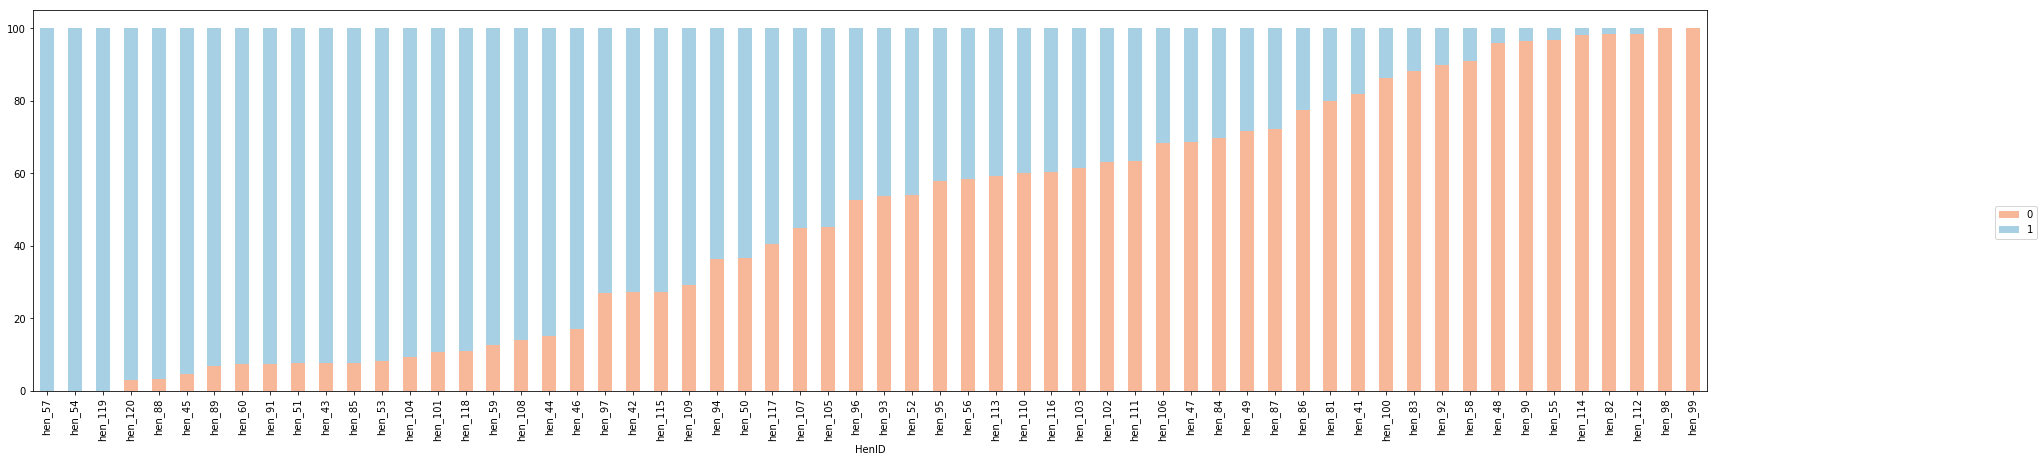

In [49]:
df_plot = df_topics.groupby(['HenID','topic']).size().reset_index().pivot(columns='topic', index='HenID', values=0)
df_plot = df_plot.fillna(0)
display(df_plot.head(3))
df_plot_normalized = df_plot.div(df_plot.sum(axis=1)*0.01, axis=0).sort_values([0]) #sort accoridng to subject 0
display(df_plot_normalized.head(3))
li_color = sns.color_palette("RdBu", nbr_topics)
df_plot_normalized.plot(x=df_plot_normalized.index, kind='bar', stacked=True, figsize=(30,7), 
                        legend=True, color=li_color).legend(bbox_to_anchor=(1.2, 0.5));
plt.savefig(os.path.join(path_save,'topic_repartition_across_hen_'+str(nbr_topics)+'.png'), 
            dpi=300, format='png', bbox_inches='tight')
plt.show()

### topic mixture across documents

for t in range(nbr_topics):
    df_plot_normalized = df_topics[['topic_'+str(i)+'_proba' for i in range(nbr_topics)]].sort_values(['topic_'+str(t)+'_proba'])
    df_plot_normalized.plot(x=df_plot_normalized.index, kind='bar', stacked=True, figsize=(40,10), 
                            legend=True).legend(bbox_to_anchor=(1.2, 0.5));
    plt.savefig(os.path.join(path_save, 'topic_mixture_across_document_'+str(t)+'.png'),dpi=300,format='png',bbox_inches='tight')
    plt.show()

### topics appearance across days

131
132


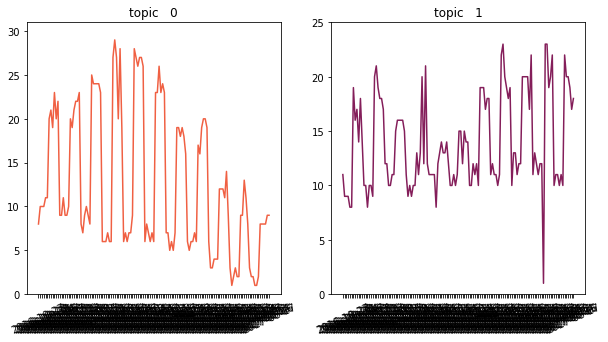

,day,documentID
0,2016-10-27,11
1,2016-10-28,9
2,2016-10-29,9


In [50]:
df_plot = df_topics.sort_values('day', ascending=True).copy()
#dico_topicID_color = {0:(0.979891, 0.90894778, 0.84827858), 1:'blue', 2:'yellow', 3:'green', 4:'grey', 5:'lime', 6:'orange'}
li_color = sns.color_palette("rocket_r", nbr_topics)
c = 2
if nbr_topics%3==0:
    c = 3
l = math.ceil(nbr_topics/c)
fig = plt.figure(figsize=(c*5, l*5))
x = df_plot['day'].unique()
for i, (t, df_) in enumerate(df_plot.groupby(['topic'])):
    ax = plt.subplot(l,c,i+1)
    df_ = df_.groupby(['day'])['documentID'].count().reset_index()
    x = df_['day'].tolist()
    y = df_['documentID'].tolist()
    print(len(x))
    plt.plot(x,y,color=li_color[i])
    plt.ylim(0,max(y)+max(int(max(y)*0.1),1))
    for label in ax.get_xticklabels():
        label.set_rotation(25) 
    plt.title('topic   '+str(t))
plt.savefig(os.path.join(path_save,'topic_appearance_across_days_.png'),dpi=300,format='png',bbox_inches='tight')
plt.show()
display(df_.head(3))    

### hens main topics across days

df_plot = df_topics.sort_values('day', ascending=True).copy()
#x = list(set(df_plot['day'].tolist()))
for t in range(nbr_topics):
    fig = plt.figure(figsize=(20,6))
    for i, (h, df_) in enumerate(df_plot.groupby(['HenID'])):
        x = df_['day'].tolist()
        y = df_['topic_'+str(t)+'_proba'].tolist()
        plt.plot(x,y)
        plt.show()
        fig = plt.figure(figsize=(20,6))
        if i==5:
            sys.exit()
    plt.title('topic   '+str(t))
    plt.show()

### main topics proba

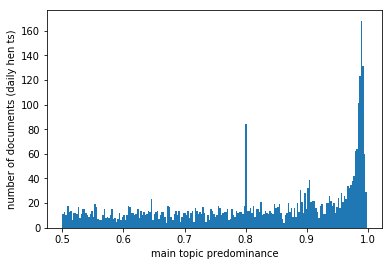

In [51]:
plt.hist(df_topics['topic_proba'].dropna(), bins=200)
plt.xlabel('main topic predominance')
plt.ylabel('number of documents (daily hen ts)');
plt.savefig(os.path.join(path_save,'main_topic_proba.png'),dpi=300,format='png',bbox_inches='tight')
plt.show()

#### plot visual time series into cluster-folders

In [52]:
for i in range(0,nbr_topics):
    path_ts = os.path.join(path_save, 'timeseries_plot_cluster', str(i))
    if not os.path.exists(path_ts):
        os.makedirs(path_ts)

In [53]:
path_ = r'D:\vm_exchange\AVIFORUM\data\extracted_info_mobility_VF\visual\TimeSeriesPlot\time_series_plot'

for i in tqdm.tqdm(range(df_topics.shape[0])):
    HenID = df_topics.iloc[i]['HenID']
    day = df_topics.iloc[i]['day']
    topic = df_topics.iloc[i]['topic']
    image_name = 'VF_'+str(day).split(' ')[0]+'_'+HenID+'.png'
    shutil.copy(os.path.join(path_, image_name), 
                os.path.join(path_save, 'timeseries_plot_cluster', str(topic), image_name))


 17%|█████████████▍                                                                 | 594/3480 [00:09<01:03, 45.60it/s]


 27%|█████████████████████▍                                                         | 946/3480 [00:18<01:03, 40.01it/s]


 49%|█████████████████████████████████████▊                                       | 1710/3480 [00:27<00:10, 167.48it/s]


 89%|█████████████████████████████████████████████████████████████████████▍        | 3100/3480 [00:38<00:07, 51.02it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 3480/3480 [00:45<00:00, 76.34it/s]

# TODO